In [20]:
import pandas as pd

import collections

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
def plot_neighbourhood(node, G, candidates, labels=False):
    # plot the neighbourhood of the top node ENSG00000101773
    sub_G = G.subgraph([n for n in G.neighbors(node)])
    candidates_in_neighbourhood = [x for x in [n for n in sub_G.nodes()] if x in candidates]

    sub_G = nx.Graph(sub_G) # unfreeze the graph
    sub_G.remove_edges_from(nx.selfloop_edges(sub_G)) # removing self-loops

    color_map = ['orangered' if node in candidates_in_neighbourhood else 'lightblue' for node in sub_G]
    pos=nx.spring_layout(sub_G)

    plt.figure(figsize=(7, 6))
    ax = plt.gca()
    ax.set_title(f"Neighbourhood of {node}")
    nx.draw_networkx(sub_G, pos=pos, with_labels=False, node_size=100, alpha=0.9, ax=ax, node_color=color_map)

    if labels:
        # plot candidates labels
        labels = {}
        for node in sub_G.nodes():
            if node in candidates_in_neighbourhood:
                labels[node] = node

        pos_higher = {}
        for k, v in pos.items():
            if(v[1]>0):
                pos_higher[k] = (v[0]-0.1, v[1]+0.1)
            else:
                pos_higher[k] = (v[0]-0.1, v[1]-0.1)
        nx.draw_networkx_labels(sub_G, pos=pos_higher, labels=labels, font_size=10, font_color='tomato')
    
    _ = ax.axis('off')

In [55]:
interactome_df = pd.read_csv('./data/Interactome_human.tsv', sep='\t', header=None)
candidates = pd.read_pickle("./data/candidateGenesList_MMAF.p")

G = nx.from_pandas_edgelist(interactome_df, 0, 1, edge_attr=True)
nonCandidates = [n for n in list(G.nodes) if n not in candidates]

### Analyze interactome

In [23]:
# number of proteins
len(G.nodes())

14465

In [24]:
# number of interactions
G.number_of_edges()

92064

Text(0, 0.5, 'number of nodes')

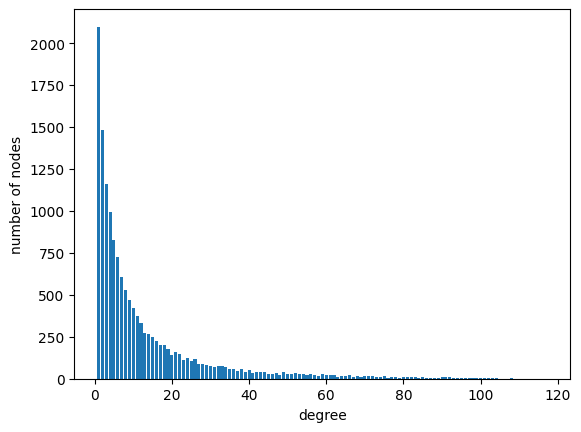

In [25]:
# degree histogram
degrees = sorted([d for n, d in G.degree()])
deg, cnt = zip(*collections.Counter(degrees).items())

plt.bar(deg, cnt)
plt.xlabel("degree")
plt.ylabel("number of nodes")

In [26]:
# average degree
sum([d for _, d in G.degree()]) / G.number_of_nodes()

12.7292084341514

### Count candidate genes for each node neighbourhood

In [27]:
# count candidate genes for each node
d = {}
d2 = {}
for node in G.nodes():
    sub_G = G.subgraph([n for n in G.neighbors(node)])
    candidates_in_neighbourhood = [x for x in [n for n in sub_G.nodes()] if x in candidates]
    candidates_in_neighbourhood_cnt = len(candidates_in_neighbourhood)
    isCandidate = True if node in candidates else False

    d[node] = candidates_in_neighbourhood_cnt
    d2[node] = [candidates_in_neighbourhood_cnt, isCandidate]

In [28]:
s = pd.Series(d, name='# candidates in neighbourhood')
s.index.name = 'Gene'
s.reset_index()
s.sort_values(ascending=False)

Gene
ENSG00000205922    1
ENSG00000066185    1
ENSG00000100348    1
ENSG00000124216    1
ENSG00000133250    1
                  ..
ENSG00000137177    0
ENSG00000226979    0
ENSG00000227507    0
ENSG00000145715    0
ENSG00000137767    0
Name: # candidates in neighbourhood, Length: 14465, dtype: int64

In [29]:
s2 = pd.Series(d2, name='# candidates in neighbourhood')
s2.index.name = 'Gene'
s2.reset_index()
s2.sort_values(ascending=False).head(20)

Gene
ENSG00000066185     [1, True]
ENSG00000137473     [1, True]
ENSG00000153060    [1, False]
ENSG00000146112    [1, False]
ENSG00000114098    [1, False]
ENSG00000163848    [1, False]
ENSG00000138587    [1, False]
ENSG00000168453    [1, False]
ENSG00000145945    [1, False]
ENSG00000100577    [1, False]
ENSG00000162526    [1, False]
ENSG00000162148    [1, False]
ENSG00000151379    [1, False]
ENSG00000155875    [1, False]
ENSG00000180806    [1, False]
ENSG00000135362    [1, False]
ENSG00000158104    [1, False]
ENSG00000161180    [1, False]
ENSG00000182173    [1, False]
ENSG00000064218    [1, False]
Name: # candidates in neighbourhood, dtype: object

Text(0, 0.5, 'number of nodes')

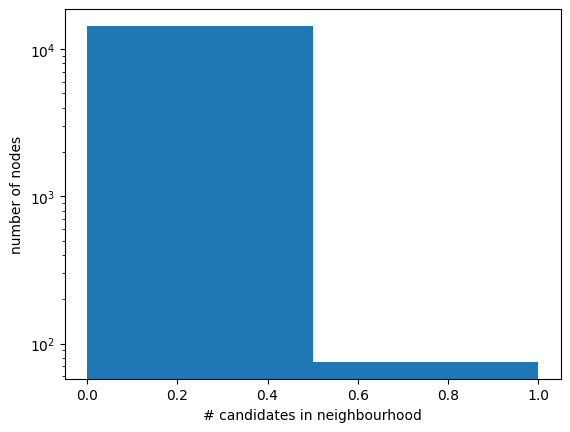

In [30]:
ax = s.plot.hist(bins=len(set(s.values)), logy=True)
ax.set_xlabel("# candidates in neighbourhood")
ax.set_ylabel("number of nodes")

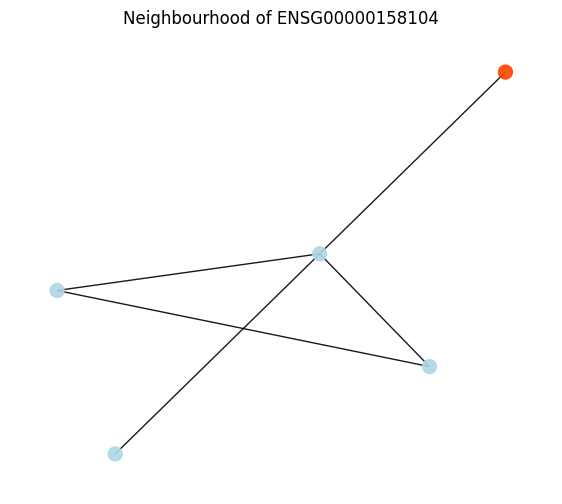

In [31]:
plot_neighbourhood("ENSG00000158104", G, candidates, labels=False)

> Information about **ENSG00000158104:**

Gene 

Protein 

In [32]:
# relation between the number of candidate genes vs degree
d = {}
for node in G.nodes():
    sub_G = G.subgraph([n for n in G.neighbors(node)])
    candidates_in_neighbourhood = [x for x in [n for n in sub_G.nodes()] if x in candidates]
    candidates_in_neighbourhood_cnt = len(candidates_in_neighbourhood)
    d[node] = [candidates_in_neighbourhood_cnt, G.degree(node)]

df = pd.DataFrame.from_dict(d, orient='index', columns=['# candidates in neighbourhood', 'degree'])

<Axes: xlabel='degree', ylabel='# candidates in neighbourhood'>

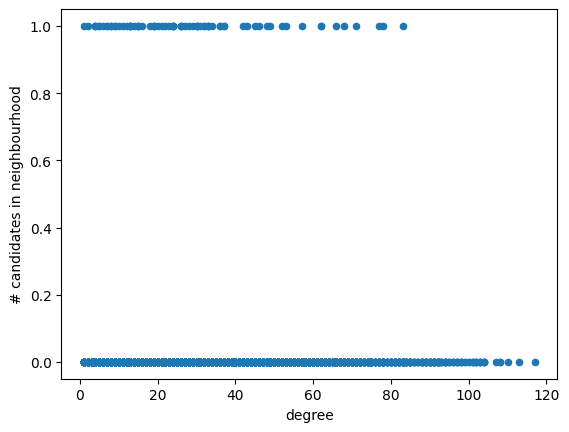

In [33]:
df.plot.scatter(x='degree', y='# candidates in neighbourhood')

In [34]:
# fraction of candidates that are present in interactome
len([candidate for candidate in candidates if candidate in G.nodes()]) / len(candidates)

# ~50% means that the second half of candidate genes has been filtered out during the building of interactome (e.g. because they form hubs >120 connections)

0.7777777777777778

In [35]:
# average degree of infertility candidate genes
d = {}

for node in G.nodes():
    if node in candidates:
        d[node] = G.degree(node)

sum([deg for n, deg in d.items()]) / len(d.keys())

10.714285714285714

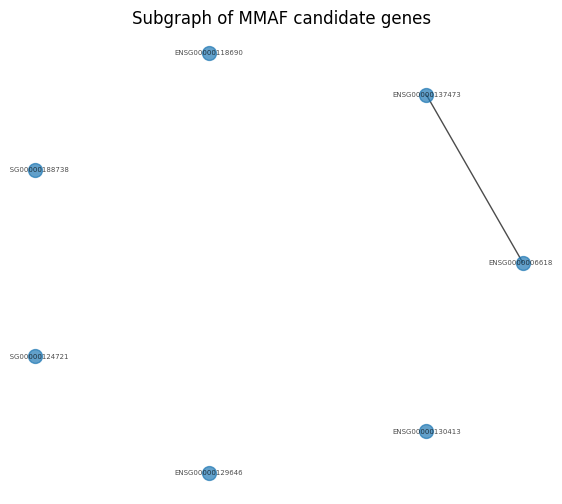

In [37]:
# subgraph of candidate genes
candidates_sub_G = G.subgraph([n for n in G.nodes() if n in candidates])

candidates_sub_G = nx.Graph(candidates_sub_G) # unfreeze the graph
candidates_sub_G.remove_edges_from(nx.selfloop_edges(candidates_sub_G)) # removing self-loops

plt.figure(figsize=(7, 6))
ax = plt.gca()
ax.set_title(f"Subgraph of MMAF candidate genes")
# nx.draw_networkx(candidates_sub_G, with_labels=False, node_size=100, alpha=0.9, ax=ax)
nx.draw_circular(candidates_sub_G, with_labels=True, node_size=100, alpha=0.7, ax=ax, font_size=5)
_ = ax.axis('off')

In [39]:
# number of nodes and edges in subgraph of candidate genes
candidates_sub_G = G.subgraph([n for n in G.nodes() if n in candidates])
candidates_sub_G.number_of_nodes(), candidates_sub_G.number_of_edges()

(7, 1)

### Score 1: Count candidate genes for each node and divide by node degree

In [43]:
# count candidate genes for each node and divide by node degree
d = {}
d2 = {}
for node in G.nodes():
    sub_G = G.subgraph([n for n in G.neighbors(node)])
    candidates_in_neighbourhood = [x for x in [n for n in sub_G.nodes()] if x in candidates]
    candidates_in_neighbourhood_cnt = len(candidates_in_neighbourhood)
    isCandidate = True if node in candidates else False
    score = candidates_in_neighbourhood_cnt / G.degree(node)
    
    d[node] = score
    d2[node] = [score, isCandidate, G.degree(node), candidates_in_neighbourhood_cnt]

In [44]:
s = pd.Series(d, name='Score 1')
s.index.name = 'Gene'
s.reset_index()
s.sort_values(ascending=False)

Gene
ENSG00000137473    1.00
ENSG00000205922    0.50
ENSG00000025708    0.25
ENSG00000241484    0.25
ENSG00000124602    0.25
                   ... 
ENSG00000137177    0.00
ENSG00000226979    0.00
ENSG00000227507    0.00
ENSG00000145715    0.00
ENSG00000137767    0.00
Name: Score 1, Length: 14465, dtype: float64

In [45]:
s2 = pd.Series(d2, name='Score 1')
s2.index.name = 'Gene'
s2.reset_index()
s2.sort_values(ascending=False)

Gene
ENSG00000137473      [1.0, True, 1, 1]
ENSG00000205922     [0.5, False, 2, 1]
ENSG00000025708    [0.25, False, 4, 1]
ENSG00000124602    [0.25, False, 4, 1]
ENSG00000241484    [0.25, False, 4, 1]
                          ...         
ENSG00000234444     [0.0, False, 1, 0]
ENSG00000218739     [0.0, False, 1, 0]
ENSG00000204136     [0.0, False, 1, 0]
ENSG00000205777     [0.0, False, 1, 0]
ENSG00000102935     [0.0, False, 1, 0]
Name: Score 1, Length: 14465, dtype: object

> Information about **ENSG00000205922:**

Gene ONECUT3

Protein O60422 *One cut domain family member 3* (**Transcriptional activator for HNF3B** -- early development; its expression emerges in the primitive streak and node at embryonic day (E) 6.5, and in the mesoderm and definitive endoderm at E7.5. and **TTR** (e.g. transports thyroid hormones in the plasma and cerebrospinal fluid))

Text(0, 0.5, 'number of nodes')

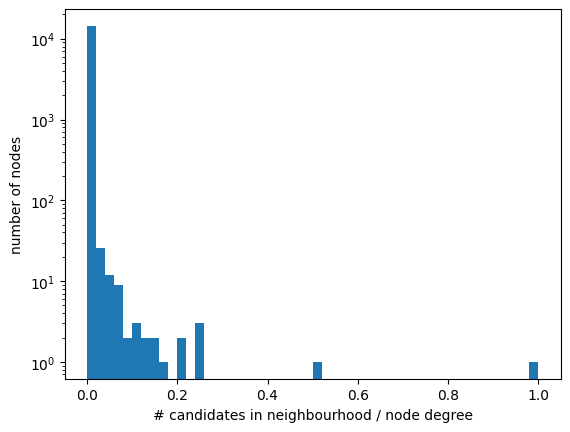

In [46]:
ax = s.plot.hist(bins=len(set(s.values)), logy=True)
# ax = s[s>0].plot.hist(bins=len(set(s.values)))
ax.set_xlabel("# candidates in neighbourhood / node degree")
ax.set_ylabel("number of nodes")

### Score 2: Harmonic centrality

In [58]:
res = nx.harmonic_centrality(G, nbunch=nonCandidates, sources=candidates)

In [62]:
res_sorted = dict(sorted(res.items(), key=lambda v: v[1], reverse=True))

In [64]:
res_sorted

{'ENSG00000172053': 3.083333333333334,
 'ENSG00000155875': 3.0833333333333335,
 'ENSG00000174099': 3.0000000000000004,
 'ENSG00000166886': 3.0,
 'ENSG00000068024': 3.0,
 'ENSG00000151365': 2.95,
 'ENSG00000100348': 2.95,
 'ENSG00000146112': 2.916666666666667,
 'ENSG00000163060': 2.916666666666667,
 'ENSG00000167987': 2.916666666666667,
 'ENSG00000161992': 2.916666666666667,
 'ENSG00000005238': 2.916666666666667,
 'ENSG00000160753': 2.916666666666667,
 'ENSG00000120075': 2.916666666666667,
 'ENSG00000064218': 2.9166666666666665,
 'ENSG00000136451': 2.866666666666667,
 'ENSG00000162526': 2.866666666666667,
 'ENSG00000162148': 2.866666666666667,
 'ENSG00000135362': 2.866666666666667,
 'ENSG00000079134': 2.8333333333333335,
 'ENSG00000105617': 2.8333333333333335,
 'ENSG00000133250': 2.8333333333333335,
 'ENSG00000161180': 2.8333333333333335,
 'ENSG00000105771': 2.8333333333333335,
 'ENSG00000104611': 2.8333333333333335,
 'ENSG00000149761': 2.8333333333333335,
 'ENSG00000145945': 2.83333333